In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import feather
from sklearn.model_selection import train_test_split_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook will extract every necessary data/datasets from out previously subsampling dataset

In [2]:
books = feather.read_dataframe('./data/books_small')
ratings = feather.read_dataframe('./data/ratings_small')
print('Number of books:', len(books.book_id.unique()))
print('Number of users:', len(ratings.user_id.unique()))

Number of books: 9590
Number of users: 1000


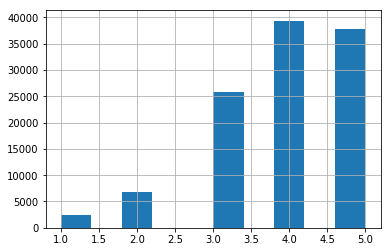

In [10]:
# Ratings distribution
ratings.rating.hist()

From the graph, we can see that the dataset contains mostly 4 and 5 ratings (as expected, since the dataset only contains ratings on popular books)

Normally, we would consider an item rated at 4 and 5 as a "hit" (or observation), since it's sufficient enough to recommend 4-rating books to users. However, in this case, since the number of 4 and 5 ratings take up 2/3 of the whole ratings, it might be a better idea to use 5-rating only as an observation.

We will split the ratings into a training set and a testing set. The testing set will only contain only 5-rating (we consider all other recommendation less than 5 as inferior). The proportion of 5-ratings we will take away from each user is 1/3, so it's better if we leave out users who have less than 3 5-rating.

It is also worth noting that we won't need a separate validation set and testing set since we will not be optimizing/tuning our models. The goal of the project at of right now is to merely inspect the qualities of different types of recommender systems and not finding the recommender system with the best performance. Optimizing will be left to later phases, most likely when building the web application.

In [11]:
# Only 5 ratings
only_five_ratings = ratings[ratings.rating==5]
only_five_ratings.shape

(37720, 3)

In [13]:
# Count how many 5-rating each user has
five_ratings_for_each_user = only_five_ratings.groupby('user_id').rating.count()
(five_ratings_for_each_user > 2).sum()

983

So 983 users have more than 3 5-rating, which is good since we only need to leave out 17 users

So we will leave behind 17 users

In [15]:
kept_users = five_ratings_for_each_user[five_ratings_for_each_user > 2].index.tolist()
kept_ratings = ratings[ratings.user_id.isin(kept_users)]
kept_ratings.shape

(110334, 3)

Now to the spliting

In [17]:
kept_4_and_less_ratings = kept_ratings[kept_ratings.rating<5]
kept_5_ratings = kept_ratings[kept_ratings.rating==5]
(kept_4_and_less_ratings.shape, kept_5_ratings.shape)

((72624, 3), (37710, 3))

In [35]:
training_5_ratings, testing_ratings = train_test_split(kept_5_ratings, 
                                                       test_size=0.33, 
                                                       random_state=42, 
                                                       stratify=kept_5_ratings[['user_id']])
(training_5_ratings.shape, testing_ratings.shape)

((25265, 3), (12445, 3))

Let's check out some users to see if we split correctly

In [36]:
kept_5_ratings[kept_5_ratings.user_id==80]

,user_id,book_id,rating
12,80,3048,5
866,80,4336,5
874,80,213,5
879,80,162,5
880,80,872,5
886,80,1055,5
888,80,4468,5


In [37]:
training_5_ratings[training_5_ratings.user_id==80]

,user_id,book_id,rating
874,80,213,5
879,80,162,5
12,80,3048,5
866,80,4336,5
888,80,4468,5


In [38]:
testing_ratings[testing_ratings.user_id==80]

,user_id,book_id,rating
886,80,1055,5
880,80,872,5


User 80 looks good for now

Let find a user with 3 5-rating

In [40]:
five_ratings_for_each_user[five_ratings_for_each_user == 3]

user_id
733      3
18752    3
21421    3
34106    3
43359    3
50801    3
Name: rating, dtype: int64

In [42]:
training_5_ratings[training_5_ratings.user_id==733]

,user_id,book_id,rating
2877,733,67,5
15818,733,677,5


In [41]:
testing_ratings[testing_ratings.user_id==733]

,user_id,book_id,rating
2876,733,1792,5


Look good! We will save these dataframe and use it for later notebooks

In [44]:
training_ratings = pd.concat([kept_4_and_less_ratings, training_5_ratings])
(training_ratings.shape, testing_ratings.shape)

((97889, 3), (12445, 3))

In [48]:
training_ratings.reset_index().drop(['index'], axis=1).to_feather('./data/training_ratings')
testing_ratings.reset_index().drop(['index'], axis=1).to_feather('./data/testing_ratings')